In [5]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
from datetime import datetime
import contextily as ctx
import itertools
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from shapely import wkt

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))
from util.isochrones import Isochrones
from util.extract_urbancenter import ExtractCenters

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(3)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,RathausWien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135


In [6]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities = cities.iloc[[2, 5, 8, 9, 15, 17]]
cities.head(20)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
5,Copenhagen,Kobenhavns Radhus,55.67537,12.56936,3090,DNK,2749
10,Marseille,Mairie de Marseille,43.29657,5.36481,2700,FRA,2228
11,London,City Hall,51.50550,-0.10490,5121,GBR,1912
17,Stockholm,Stadshus,59.32773,18.05362,3669,SWE,2973
19,Helsinki,Helsingin kaupungintalo,60.16812,24.95299,2241,FIN,3244


In [7]:
CACHE = os.path.join(DROOT, '3-traveltime-cache', 'cache.main.db')
isochrone_client   = Isochrones(bing_key=os.environ['BING_API_KEY'], db=CACHE)
urbancenter_client = ExtractCenters(src_dir=os.path.join(DROOT, '2-external'), 
                                    target_dir=os.path.join(DROOT, '2-popmasks'))

In [10]:
for pid, city in cities[cities.City == 'Brussels'].iterrows():
    
    # Extract urban center and read in as pickle
    pcl_path = urbancenter_client.extract_city(city.City, city.ID_HDC_G0)
    gdf = gpd.GeoDataFrame(pd.read_pickle(pcl_path))
    gdf = gdf.rename(columns={'geometry': 'raster'}).set_geometry('raster')
    
    # Check if records are all done    
    isochrone_config = [
        ('driving', 'driving',      datetime(2023, 6, 13, 8, 30, 0),  'b'),
        ('driving', 'driving',      datetime(2023, 6, 13, 8, 30, 0),  'g'),
        # ('transit', 'transit-peak', datetime(2023, 6, 13, 8, 30, 37), 'b'),
        # ('transit', 'transit',      datetime(2023, 6, 13, 13, 0, 37), 'b'), 
        # ('cycling', 'cycling',      datetime(2023, 6, 13, 8, 30, 0),  'g'), 
        # ('walking', 'walking',      datetime(2023, 6, 13, 8, 30, 0),  'g')
    ]
    
    # Retrieve all isochrones based on above configuration
    isochrones = isochrone_client.get_isochrones(
        city_id=city.ID_HDC_G0, 
        points=enumerate(gdf.centroid.to_crs("EPSG:4326")),
        tt_mnts=[15], #35, 45],
        config=isochrone_config,
        fetch=False
    )
    isochrones = isochrones.merge(gdf, left_on='pid', right_index=True)
    isochrones.isochrone = isochrones.isochrone.fillna(Polygon())
    isochrones['reach_km2'] = isochrones.isochrone.to_crs(isochrones.isochrone.estimate_utm_crs()).area
    
    break

isochrones.head(2)

INFO:root:Population raster extract already exists: Brussels (2135 with 0m bufferr)
INFO:root:Converted batch to timezone Europe/Brussels.
INFO:root:Out of total 532, 100.0% cached.


,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,source,city_id,isochrone,cell_pop,raster,reach_km2
0,2135-0-driving-15m-b,0,POINT (4.41380 50.94912),15,driving,driving,2023-06-13 08:30:00+02:00,b,2135,"POLYGON ((4.29005 50.88806, 4.31066 50.89543, ...",1231.189087,"POLYGON ((331000.000 5973000.000, 331000.000 5...",1.736811e+08
1,2135-0-driving-15m-g,0,POINT (4.41380 50.94912),15,driving,driving,2023-06-13 08:30:00+02:00,g,2135,"POLYGON ((4.45086 51.01154, 4.44992 51.01525, ...",1231.189087,"POLYGON ((331000.000 5973000.000, 331000.000 5...",2.733883e+08


<Axes: ylabel='Frequency'>

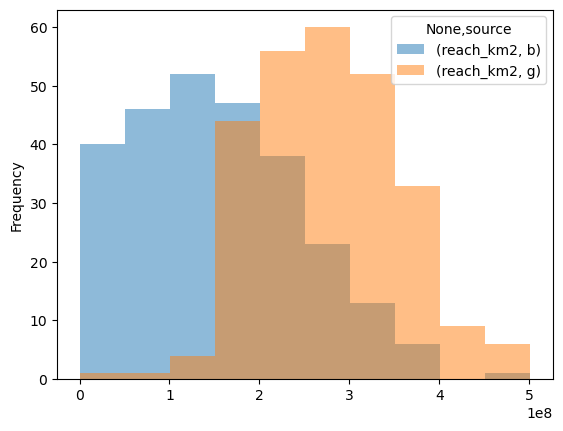

In [15]:
isochrones.source = isochrones.source.rename({'b': 'bing', 'g': 'graphhopper'})
comparison = isochrones.pivot_table(index='pid', columns='source', values=['reach_km2'])
comparison.plot.hist(alpha=0.5)